In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
          'font.size':13,
         'figure.max_open_warning': 0}

plt.rcParams.update(params)
import matplotlib.colors as colors
from astropy.time import Time

In [3]:
import dask.array as da
from daskms import xds_from_table, xds_to_table
from dask.distributed import Client

import numpy as np

In [4]:
client = Client(n_workers=4, 
                threads_per_worker=4, 
                processes=True, 
                memory_limit='8GB'
                )
client

/home/nkateko/anaconda3/envs/daskms/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38329 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38329/status,
Dashboard: http://127.0.0.1:38329/status,Workers: 4
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45351,Workers: 4
Dashboard: http://127.0.0.1:38329/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:42025,Total threads: 4
Dashboard: http://127.0.0.1:44811/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:44351,


In [5]:
ds = xds_from_table("1548939342.ms")

In [6]:
print(ds)

[<xarray.Dataset> Size: 1GB
Dimensions:          (row: 31875, flagcat: 1, chan: 1024, corr: 2, uvw: 3)
Coordinates:
    ROWID            (row) int64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: row, flagcat, chan, corr, uvw
Data variables: (12/24)
    STATE_ID         (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    FLAG_CATEGORY    (row, flagcat, chan, corr) bool 65MB dask.array<chunksize=(10000, 1, 1024, 2), meta=np.ndarray>
    TIME             (row) float64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
    ANTENNA2         (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    SIGMA            (row, corr) float32 255kB dask.array<chunksize=(10000, 2), meta=np.ndarray>
    FEED1            (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    ...               ...
    WEIGHT           (row, corr) float32 255kB dask.array<chunksize=(10000, 2), meta=np.ndarray>
    FLAG             (ro

In [7]:
# Let us now try to get the visibilities
vis = ds[0]['DATA']

In [8]:
# Extract the observation table
# Code credit: Franscios

obs_table = xds_from_table("1548939342.ms::OBSERVATION")
print("Observation Table Keys:")
for key in obs_table[0].keys():
    print(f'{key}: {obs_table[0][key].values}')

# Extract observation start and end time
start_time = obs_table[0]["TIME_RANGE"].values[0][0]
end_time = obs_table[0]["TIME_RANGE"].values[0][1]
start_time_days = start_time / (24 * 3600) #seconds -> mjd -> convert back to UTC or SAST
end_time_days = end_time / (24 * 3600)

start_time = Time(start_time_days, format='mjd').to_datetime()
end_time = Time(end_time_days, format='mjd').to_datetime()
print(f"Start Date: {start_time}")
print(f"End Date: {end_time}")

Observation Table Keys:
TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
SCHEDULE: [['unavailable']]
SCHEDULE_TYPE: ['unknown']
FLAG_ROW: [False]
OBSERVER: ['Lindsay']
PROJECT: ['20190131-0012']
RELEASE_DATE: [5.05565639e+09]
TELESCOPE_NAME: ['MeerKAT']
LOG: [['unavailable']]
Start Date: 2019-01-31 12:56:12.122526
End Date: 2019-01-31 12:59:48.031192


In [9]:
for key in ds[0].keys():
    print(key)

STATE_ID
FLAG_CATEGORY
TIME
ANTENNA2
SIGMA
FEED1
SCAN_NUMBER
TIME_CENTROID
ANTENNA1
INTERVAL
FLAG_ROW
EXPOSURE
IMAGING_WEIGHT
PROCESSOR_ID
FEED2
OBSERVATION_ID
WEIGHT_SPECTRUM
FIELD_ID
WEIGHT
FLAG
ARRAY_ID
DATA_DESC_ID
UVW
DATA


In [10]:
obs_table = xds_from_table("1548939342.ms::OBSERVATION")
print(obs_table)

[<xarray.Dataset> Size: 81B
Dimensions:         (row: 1, obs-exts: 2, schedule: 1, log: 1)
Coordinates:
    ROWID           (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, obs-exts, schedule, log
Data variables:
    TIME_RANGE      (row, obs-exts) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    SCHEDULE        (row, schedule) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCHEDULE_TYPE   (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    FLAG_ROW        (row) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    OBSERVER        (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    PROJECT         (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    RELEASE_DATE    (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TELESCOPE_NAME  (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    LOG             (row, log) object 8B dask.array<chunksize=(1, 1), meta=

In [11]:
for key in obs_table[0].keys():

    print(f'{key}: {obs_table[0][key].values}')


TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
SCHEDULE: [['unavailable']]
SCHEDULE_TYPE: ['unknown']
FLAG_ROW: [False]
OBSERVER: ['Lindsay']
PROJECT: ['20190131-0012']
RELEASE_DATE: [5.05565639e+09]
TELESCOPE_NAME: ['MeerKAT']
LOG: [['unavailable']]


In [12]:
A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
inter = ds[0]["INTERVAL"]
print(f'Total number of antennas used {nants}')
print('Interval Table Shape: ',inter.shape)
print(f'Dump rate is {np.median(inter)} s');

Total number of antennas used 50
Interval Table Shape:  (31875,)
Dump rate is 7.9966169712 s


In [13]:
# Get the UVW points
ds[0]['UVW']

<xarray.DataArray 'UVW' (row: 31875, uvw: 3)> Size: 765kB
dask.array<read~UVW~1548939342.ms, shape=(31875, 3), dtype=float64, chunksize=(10000, 3), chunktype=numpy.ndarray>
Coordinates:
    ROWID    (row) int64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: row, uvw

In [14]:
u,v,w = ds[0]['UVW'][:,0],ds[0]['UVW'][:,1],ds[0]['UVW'][:,2]

Text(0, 0.5, 'v')

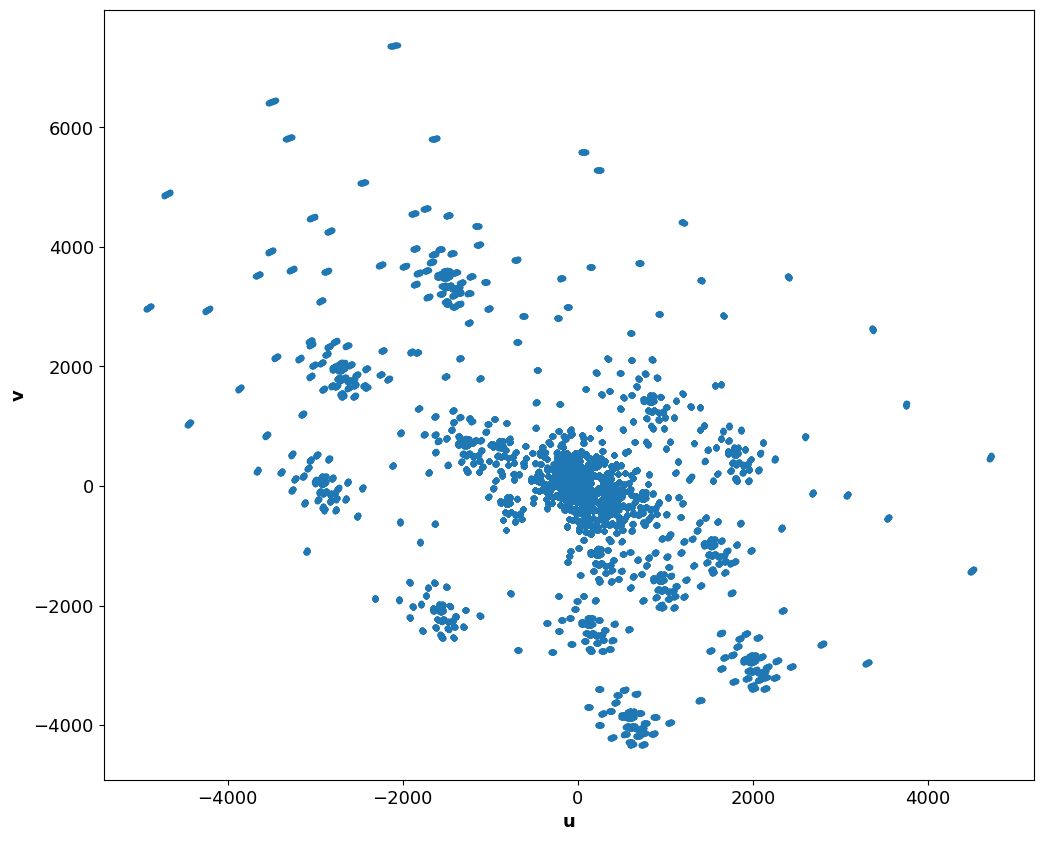

In [15]:
plt.plot(u,v,'.')
plt.xlabel('u')
plt.ylabel('v')

In [16]:
# Read the ANTENNA table
antenna_table = xds_from_table("1548939342.ms::ANTENNA")

print(antenna_table)

[<xarray.Dataset> Size: 5kB
Dimensions:        (row: 50, xyz: 3)
Coordinates:
    ROWID          (row) int64 400B dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: row, xyz
Data variables:
    MOUNT          (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    OFFSET         (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
    FLAG_ROW       (row) bool 50B dask.array<chunksize=(50,), meta=np.ndarray>
    STATION        (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    TYPE           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    DISH_DIAMETER  (row) float64 400B dask.array<chunksize=(50,), meta=np.ndarray>
    NAME           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    POSITION       (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
Attributes:
    __daskms_partition_schema__:  ()]


In [17]:
antenna_table[0]['NAME'].values

array(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm009', 'm010',
       'm011', 'm013', 'm014', 'm015', 'm017', 'm019', 'm020', 'm021',
       'm022', 'm023', 'm024', 'm025', 'm027', 'm028', 'm029', 'm031',
       'm032', 'm033', 'm035', 'm037', 'm038', 'm039', 'm040', 'm041',
       'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049',
       'm050', 'm051', 'm055', 'm056', 'm057', 'm058', 'm059', 'm060',
       'm061', 'm062'], dtype=object)

In [18]:
antenna_table[0]['POSITION']

<xarray.DataArray 'POSITION' (row: 50, xyz: 3)> Size: 1kB
dask.array<read~POSITION~1548939342.ms/ANTENNA, shape=(50, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>
Coordinates:
    ROWID    (row) int64 400B dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: row, xyz

In [19]:
print(antenna_table[0]['POSITION'].values)

[[ 5109224.28330101  2006790.34830945 -3239100.60432023]
 [ 5109237.64002439  2006805.67700518 -3239069.99463992]
 [ 5109224.98529035  2006765.00133159 -3239115.19822119]
 [ 5109247.71453184  2006736.9651357  -3239096.13442916]
 [ 5109244.68809625  2006674.4233089  -3239139.81459295]
 [ 5109222.76106102  2006688.94849795 -3239165.94167899]
 [ 5109132.82118802  2006798.06539449 -3239242.19060095]
 [ 5109046.34250297  2006823.98222895 -3239363.79206003]
 [ 5109122.96650556  2006849.69137709 -3239225.88024209]
 [ 5109048.21915394  2006984.47473988 -3239261.95549118]
 [ 5109082.89642682  2007045.23603689 -3239169.09259079]
 [ 5109139.53273202  2006992.24816646 -3239111.37666584]
 [ 5109193.73983259  2007001.70002865 -3239019.08733502]
 [ 5109122.95791977  2006942.91666107 -3239168.36029351]
 [ 5109142.92017108  2006871.50044504 -3239180.65456621]
 [ 5109272.06096906  2006500.0158821  -3239203.48775662]
 [ 5109454.06397737  2006488.737612   -3238920.41294648]
 [ 5109368.62411322  2006509.64

In [20]:
import numpy as np
from itertools import combinations
from daskms import xds_from_table

# Read the ANTENNA table from the MS file
antenna_table = xds_from_table("1548939342.ms::ANTENNA")

# Extract the 'POSITION' and 'NAME' fields for all antennas
positions = antenna_table[0]['POSITION'].values  # Antenna positions in meters
antenna_names = antenna_table[0]['NAME'].values  # Antenna names

# Check if there are at least 2 antennas
if len(positions) < 2:
    print("Not enough antennas to calculate distances.")
else:
    # Calculate distances between all pairs of antennas
    antenna_pairs = list(combinations(range(len(positions)), 2))  # All unique antenna pairs

    distances = []
    for i, j in antenna_pairs:
        pos1 = positions[i]
        pos2 = positions[j]

        # Calculate the Euclidean distance between the two antennas
        distance = np.linalg.norm(pos2 - pos1)
        distances.append((i, j, distance))

    # Check if distances were calculated
    if distances:
        # Find the minimum and maximum distances
        min_distance = min(distances, key=lambda x: x[2])  # Shortest distance
        max_distance = max(distances, key=lambda x: x[2])  # Longest distance

        # Get antenna names for the shortest and longest distances
        min_ant1_name = antenna_names[min_distance[0]]
        min_ant2_name = antenna_names[min_distance[1]]
        max_ant1_name = antenna_names[max_distance[0]]
        max_ant2_name = antenna_names[max_distance[1]]

        # Print out the shortest distance with antenna names
        print(f"Shortest distance is between antenna {min_ant1_name} and antenna {min_ant2_name}: {min_distance[2]:.2f} meters")

        # Print out the longest distance with antenna names
        print(f"Longest distance is between antenna {max_ant1_name} and antenna {max_ant2_name}: {max_distance[2]:.2f} meters")
    else:
        print("No distances calculated. Please check the antenna positions.")


Shortest distance is between antenna m000 and antenna m002: 29.26 meters
Longest distance is between antenna m048 and antenna m060: 7697.58 meters


In [21]:
# Load the observation table
obs_table = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")

# Print observation table keys and the first value for each key
print("Observation Table Keys and First Values:")
for key in obs_table[0].keys():
    # Print the key and its first value
    print(f'{key}: {obs_table[0][key].values[0]}')


Observation Table Keys and First Values:
RESOLUTION: [835937.5 835937.5 835937.5 ... 835937.5 835937.5 835937.5]
IF_CONV_CHAIN: 0
FREQ_GROUP_NAME: none
EFFECTIVE_BW: [835937.5 835937.5 835937.5 ... 835937.5 835937.5 835937.5]
MEAS_FREQ_REF: 5
REF_FREQUENCY: 1284000000.0
FLAG_ROW: False
CHAN_WIDTH: [835937.5 835937.5 835937.5 ... 835937.5 835937.5 835937.5]
CHAN_FREQ: [8.56000000e+08 8.56835938e+08 8.57671875e+08 ... 1.70949219e+09
 1.71032812e+09 1.71116406e+09]
NAME: none
NET_SIDEBAND: 1
TOTAL_BANDWIDTH: 856000000.0
FREQ_GROUP: 0
NUM_CHAN: 1024


In [22]:
# Load the observation table
obs_table = xds_from_table("1548939342.ms::FEED")

# Print observation table keys and the first value for each key
print("Observation Table Keys and First Values:")
for key in obs_table[0].keys():
    # Print the key and its first value
    print(f'{key}: {obs_table[0][key].values[0]}')


Observation Table Keys and First Values:
NUM_RECEPTORS: 2
TIME: 0.0
RECEPTOR_ANGLE: [-1.57079633 -1.57079633]
POLARIZATION_TYPE: ['X' 'Y']
FEED_ID: 0
INTERVAL: 0.0
POL_RESPONSE: [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
SPECTRAL_WINDOW_ID: -1
POSITION: [0. 0. 0.]
BEAM_ID: 1
BEAM_OFFSET: [[0. 0.]
 [0. 0.]]
ANTENNA_ID: 0


In [23]:
# Read the SPECTRAL table
spectral_table = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")


frequencies = spectral_table[0]['CHAN_FREQ'].values
nchannels = spectral_table[0]['NUM_CHAN'].values[0]
channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0]


summary = {
    'Frequencies': frequencies,
    'No_Channeles': nchannels,
    'Channel_Width': channel_width,
    }

/tmp/ipykernel_137062/140599003.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=84))


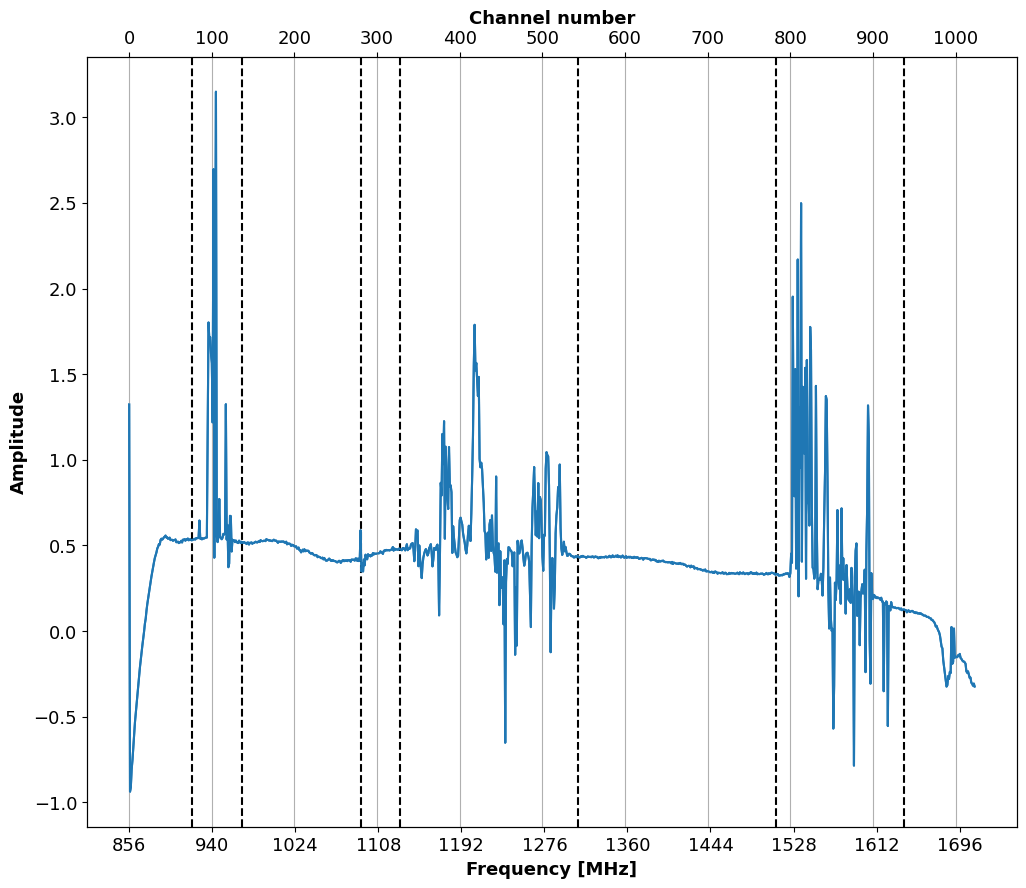

In [24]:
#
# Plot the average across frequency slice
#
frequencies = spectral_table[0]['CHAN_FREQ'].values.T
absdata = np.abs(vis[500,:,0]).compute()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(frequencies/1.e6,np.log10(absdata),'-')
ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=84))
ax1.axvline(x = 920, color = 'black', linestyle = '--')     # RFI 1
ax1.axvline(x = 970, color = 'black', linestyle = '--')     # RFI 1

ax1.axvline(x = 1090, color = 'black', linestyle = '--')    # RFI 2 residual

ax1.axvline(x = 1130, color = 'black', linestyle = '--')    # RFI 2
ax1.axvline(x = 1310, color = 'black', linestyle = '--')    # RFI 2

ax1.axvline(x = 1510, color = 'black', linestyle = '--')    # RFI 3
ax1.axvline(x = 1640, color = 'black', linestyle = '--')    # RFI 3

ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.log10(absdata))
ax2.set_xticks(np.arange(0,absdata.shape[0], step=100))
ax2.set_xlabel('Channel number')
plt.grid()


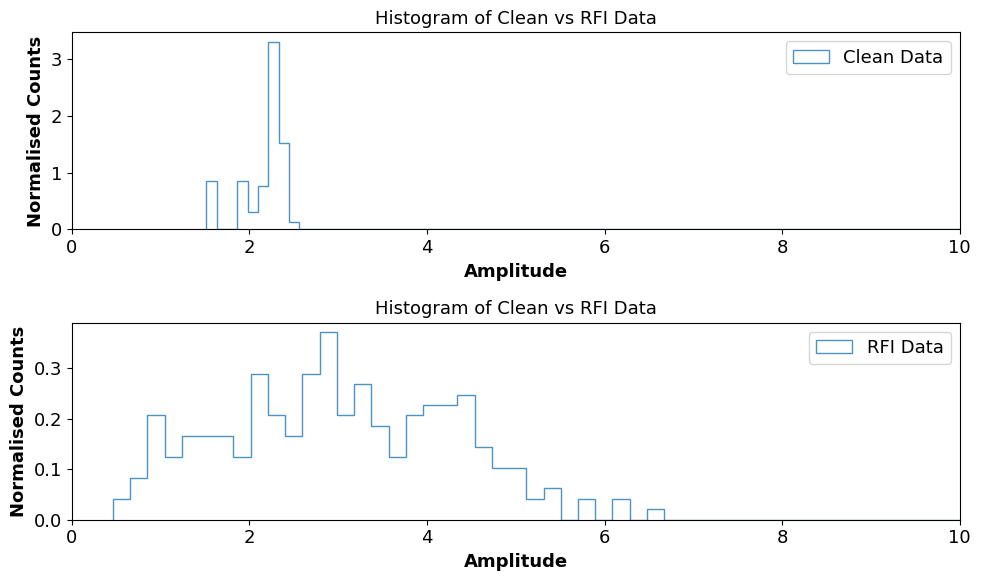

In [25]:
vis_clean = []

vis_rfi = []

# Load the measurement set (MS) table into a Dask array
datasets = xds_from_table("1548939342.ms")


for a1 in range(0,10):

   for a2 in range(1,10):

      # print(antenna_table[0].NAME.data[a1].compute(), antenna_table[0].NAME.data[a2].compute())

      idx = np.where((datasets[0].ANTENNA1 == a1) & (datasets[0].ANTENNA2 == a2))[0]

      # antenna_table[0].NAME.data[a1].compute(), antenna_table[0].NAME.data[a2].compute()

   vis_rfi.append(np.abs(datasets[0].DATA.data[idx][:,440,0].compute()))

   vis_clean.append(np.abs(datasets[0].DATA.data[idx][:,700,0].compute()))

combined_array_clean = np.concatenate(vis_clean)

combined_array_rfi = np.concatenate(vis_rfi)

# Plot histograms
plt.figure(figsize=(10, 6))

# Histogram for clean data
plt.subplot(2, 1, 1)
plt.hist(combined_array_clean, bins=500, alpha=0.8, histtype='step', lw=1, density=True, label="Clean Data")
plt.xlim(0, 10)
plt.xlabel('Amplitude')
plt.ylabel('Normalised Counts')
plt.title('Histogram of Clean vs RFI Data')
plt.legend()

# Histogram for RFI-affected data
plt.subplot(2, 1, 2)
plt.hist(combined_array_rfi, bins=500, alpha=0.8, histtype='step', lw=1, density=True, label="RFI Data")

# Set the x-axis limit to focus on the range 0-10
plt.xlim(0, 10)

# Add labels and title
plt.xlabel('Amplitude')
plt.ylabel('Normalised Counts')
plt.title('Histogram of Clean vs RFI Data')

# Add legend
plt.legend()
plt.tight_layout()
plt.savefig("histogram_of_clean_and_rfi_plot.png")
plt.show()

In [26]:
# Calculate measures of spread (standard deviation and IQR)
std_clean = np.std(combined_array_clean)
std_rfi = np.std(combined_array_rfi)

iqr_clean = np.percentile(combined_array_clean, 75) - np.percentile(combined_array_clean, 25)
iqr_rfi = np.percentile(combined_array_rfi, 75) - np.percentile(combined_array_rfi, 25)

print(f"Clean Data - Standard Deviation: {std_clean:.2f}, IQR: {iqr_clean:.2f}")
print(f"RFI Data - Standard Deviation: {std_rfi:.2f}, IQR: {iqr_rfi:.2f}")



Clean Data - Standard Deviation: 17.22, IQR: 0.26
RFI Data - Standard Deviation: 27.67, IQR: 2.24


In [27]:
from scipy.stats import kurtosis, skew

# Calculate kurtosis and skewness for both datasets
kurt_clean = kurtosis(combined_array_clean)
kurt_rfi = kurtosis(combined_array_rfi)

skew_clean = skew(combined_array_clean)
skew_rfi = skew(combined_array_rfi)

# Print the kurtosis and skewness values
print(f"Clean Data - Kurtosis: {kurt_clean:.2f}, Skewness: {skew_clean:.2f}")
print(f"RFI Data - Kurtosis: {kurt_rfi:.2f}, Skewness: {skew_rfi:.2f}")

Clean Data - Kurtosis: 5.11, Skewness: 2.67
RFI Data - Kurtosis: 5.09, Skewness: 2.66


Visibilities between antennas: m001 and m001


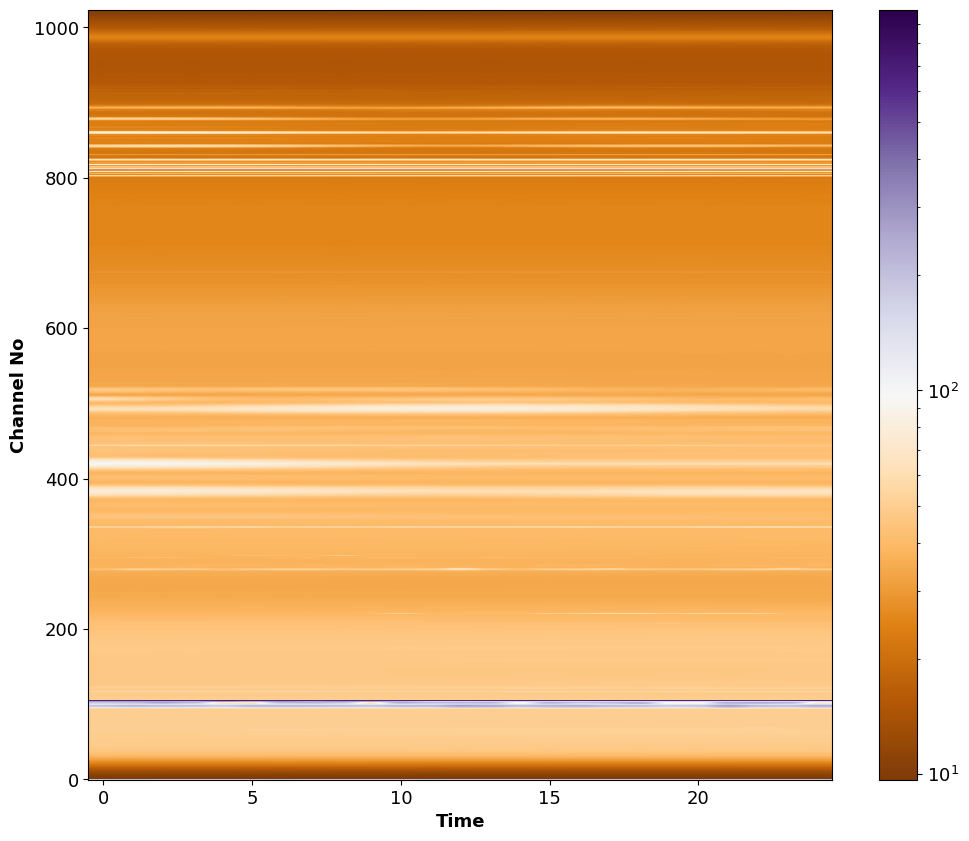

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Define antennas for short and long baseline
a1 = 1  # Example for short baseline
a2 = 1  # Example for long baseline

# Get the antenna names
antenna_name_1 = antenna_table[0].NAME.data[a1].compute()
antenna_name_2 = antenna_table[0].NAME.data[a2].compute()

# Extract indices for the baselines corresponding to antenna pair (a1, a2)
idx = np.where((datasets[0].ANTENNA1 == a1) & (datasets[0].ANTENNA2 == a2))[0]

# Compute and get the visibilities for this antenna pair in the selected frequency range
visual = datasets[0].DATA.data[idx].compute()

# Visualize the visibilities in the frequency range of 600-700
plt.imshow(np.abs(visual[:,:,0]).T,     # time, frequency, polarization
           aspect='auto', 
           origin='lower', 
           cmap='PuOr', 
           norm=colors.LogNorm()
           )

plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.savefig("short_baseline_visibility_plot.png")
# Show the names of the antennas used
print(f"Visibilities between antennas: {antenna_name_1} and {antenna_name_2}")


Visibilities between antennas: m001 and m049


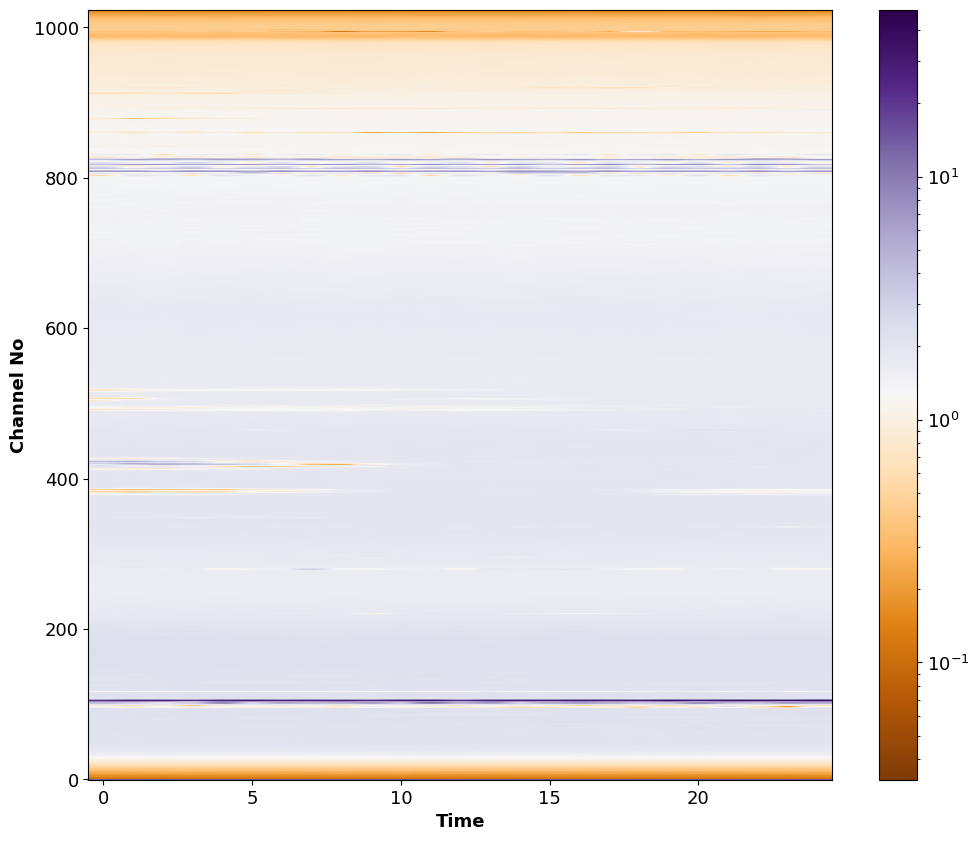

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Define antennas for short and long baseline
a1 = 1  # Example for short baseline
a2 = 39  # Example for long baseline

# Get the antenna names
antenna_name_1 = antenna_table[0].NAME.data[a1].compute()
antenna_name_2 = antenna_table[0].NAME.data[a2].compute()

# Extract indices for the baselines corresponding to antenna pair (a1, a2)
idx = np.where((datasets[0].ANTENNA1 == a1) & (datasets[0].ANTENNA2 == a2))[0]

# Compute and get the visibilities for this antenna pair in the selected frequency range
visual = datasets[0].DATA.data[idx].compute()

# Visualize the visibilities in the frequency range of 600-700
plt.imshow(np.abs(visual[:,:,0]).T,     # time, frequency, polarization
           aspect='auto', 
           origin='lower', 
           cmap='PuOr', 
           norm=colors.LogNorm()
           )

plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.savefig("long_baseline_visibility_plot.png")
# Show the names of the antennas used
print(f"Visibilities between antennas: {antenna_name_1} and {antenna_name_2}")


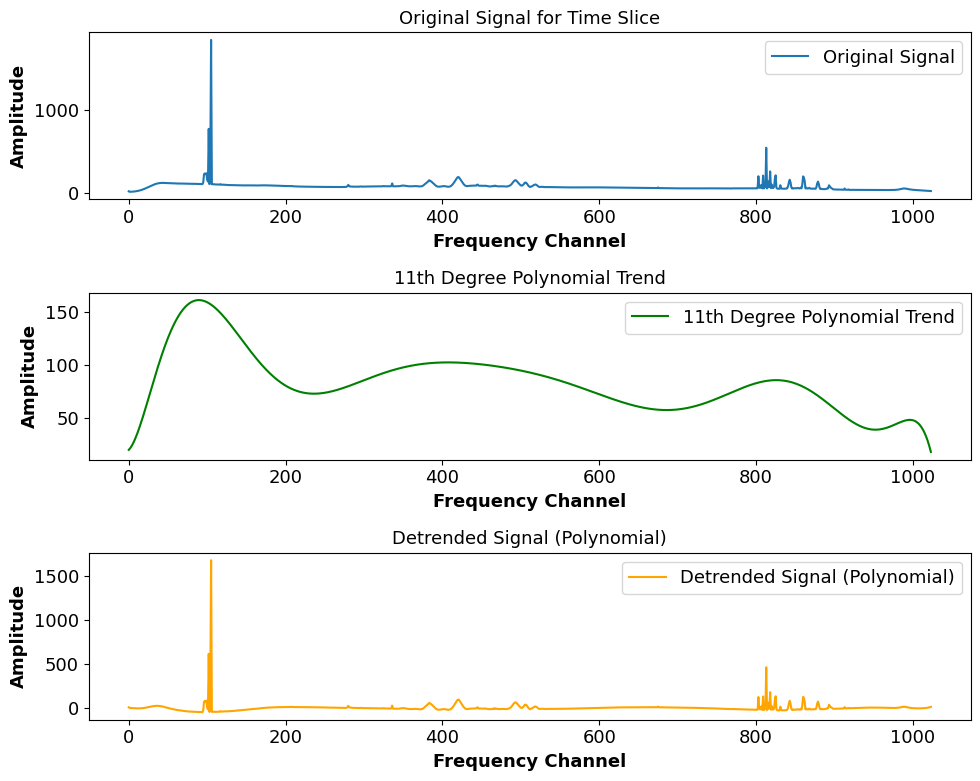

Mean of residuals: 0.0000
Standard deviation of residuals: 62.2389


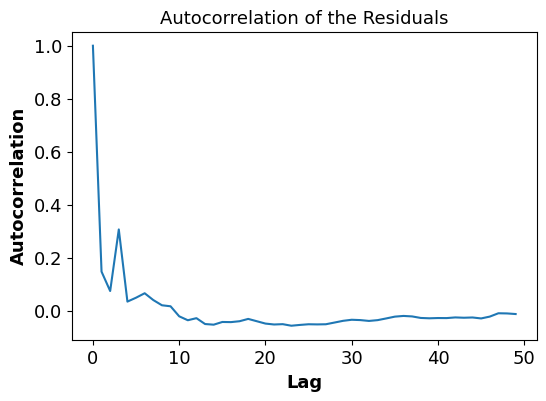

Chi-squared value: 28166.7273
Degrees of freedom: 1012
p-value for chi-squared test: 0.0
Shapiro-Wilk test statistic: 0.20370236618039672
p-value for Shapiro-Wilk test: 2.7929519588613356e-54


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import chi2, shapiro

# Select a time slice (adjust the indices according to your data)
time_slice = 30  # Example time index
frequency_idx = 0  # Example frequency index or polarization

# Extract the visibility data for the chosen baseline over time
original_signal = np.abs(vis[time_slice, :, frequency_idx].values)  # Ensure it is a NumPy array

# Polynomial detrending: Fit a polynomial to the data and remove the trend
degree = 11  # Degree of the polynomial
x_vals = np.arange(len(original_signal))  # x-values representing the indices of the signal

# Fit a polynomial to the signal
polynomial_coefficients = np.polyfit(x_vals, original_signal, degree)

# Compute the trend using the polynomial coefficients
trend = np.polyval(polynomial_coefficients, x_vals)

# Detrend the signal by subtracting the trend
detrended_signal_poly = original_signal - trend

# Plot the original signal, the polynomial trend, and the detrended signal
plt.figure(figsize=(10, 8))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(x_vals, original_signal, label='Original Signal')
plt.title('Original Signal for Time Slice')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

# Polynomial trend
plt.subplot(3, 1, 2)
plt.plot(x_vals, trend, label=f'{degree}th Degree Polynomial Trend', color='green')
plt.title(f'{degree}th Degree Polynomial Trend')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

# Detrended signal
plt.subplot(3, 1, 3)
plt.plot(x_vals, detrended_signal_poly, label='Detrended Signal (Polynomial)', color='orange')
plt.title('Detrended Signal (Polynomial)')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()

plt.savefig("signal_detrending_plot.png")
plt.show()

# Statistical analysis of the detrended signal

# 1. Mean and standard deviation of the detrended signal
mean_residual = np.mean(detrended_signal_poly)
std_residual = np.std(detrended_signal_poly)

print(f"Mean of residuals: {mean_residual:.4f}")
print(f"Standard deviation of residuals: {std_residual:.4f}")

# 2. Autocorrelation of the residuals
autocorr = np.correlate(detrended_signal_poly, detrended_signal_poly, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Keep the positive lags
autocorr /= autocorr[0]  # Normalize by the zero-lag value

plt.figure(figsize=(6, 4))
plt.plot(autocorr[:50])  # Plot first 50 lags
plt.title("Autocorrelation of the Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("signal_residuals_plot.png")
plt.show()

# 3. Chi-squared test for goodness of fit
# Calculate the expected values (the polynomial trend) and observed values (original signal)
chi_squared = np.sum(((original_signal - trend) ** 2) / trend)
dof = len(original_signal) - (degree + 1)  # Degrees of freedom: n - (degree + 1)
p_value = chi2.sf(chi_squared, dof)

print(f"Chi-squared value: {chi_squared:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value for chi-squared test: {p_value:}")

# 4. Shapiro-Wilk test for normality of residuals
stat, p_value_normality = shapiro(detrended_signal_poly)
print(f"Shapiro-Wilk test statistic: {stat:}")
print(f"p-value for Shapiro-Wilk test: {p_value_normality:}")


/home/nkateko/anaconda3/envs/daskms/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 124.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


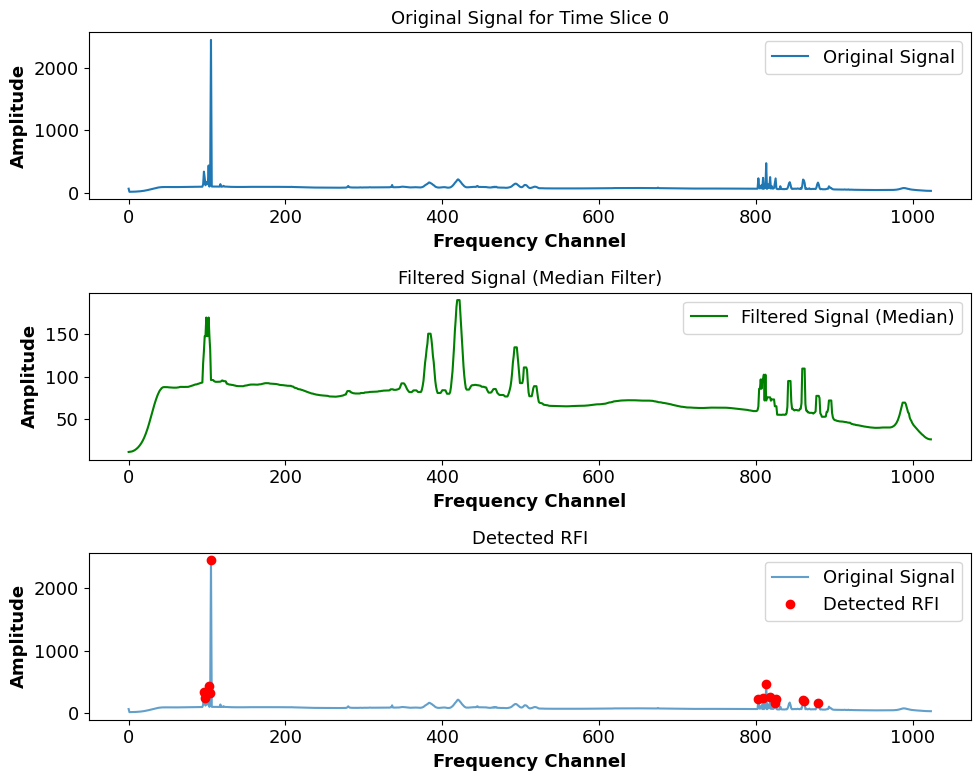

RFI detected at indices for time slice 0: [ 96  97 102 104 105 803 809 813 818 824 825 860 861 879]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Assume 'vis' is your 3D visibility data [time, frequency, polarization]
# Extract the visibility data for a specific polarization slice (e.g., polarization 0)
original_signal = np.abs(vis[:, :, 0])  # Data for polarization 0

# Apply median filtering along the frequency axis
window_size = 7  # Window size for the median filter (can adjust based on your data)
# Applying 1D filter along frequency axis (axis=1) for each time step
filtered_signal = np.apply_along_axis(medfilt, 1, original_signal, kernel_size=window_size)

# Detect RFI: Calculate the difference between original and filtered signals
# Large deviations from the filtered signal are potential RFI
rfi_mask = np.abs(original_signal - filtered_signal) > 3 * np.std(filtered_signal, axis=1, keepdims=True)

# Compute the boolean mask to get the indices where RFI is detected
rfi_mask_computed = rfi_mask.compute()  # Compute the mask

# Plot the original signal, filtered signal, and detected RFI points
plt.figure(figsize=(10, 8))

# Choose a specific time slice to plot (for example, time index 0)
time_slice = 0  # You can change this to visualize different time slices

# Plot the original signal for the selected time slice
plt.subplot(3, 1, 1)
plt.plot(original_signal[time_slice, :], label='Original Signal')
plt.title(f'Original Signal for Time Slice {time_slice}')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

# Plot the filtered signal for the same time slice
plt.subplot(3, 1, 2)
plt.plot(filtered_signal[time_slice, :], label='Filtered Signal (Median)', color='green')
plt.title('Filtered Signal (Median Filter)')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

# Plot detected RFI points on top of the original signal
plt.subplot(3, 1, 3)
plt.plot(original_signal[time_slice, :], label='Original Signal', alpha=0.7)

# Use the computed mask for indexing
rfi_indices = np.where(rfi_mask_computed[time_slice, :])[0]
plt.plot(rfi_indices, original_signal[time_slice, rfi_indices], 'ro', label='Detected RFI')
plt.title('Detected RFI')
plt.xlabel('Frequency Channel')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.savefig("RFI_detection_plot.png")
plt.show()

# Output the indices where RFI is detected for the selected time slice
print(f"RFI detected at indices for time slice {time_slice}: {rfi_indices}")


## 